# Kernel Methods using the Dual Perceptron and Support Vector Machine

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We know that the XOR function for two binary variables produces a non-linearly separable dataset.

As shown below:

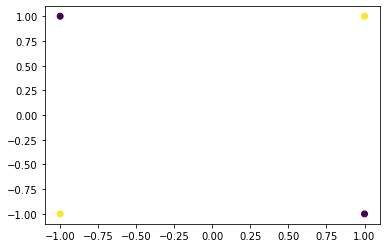

In [2]:
X = np.array([[1,-1,-1],
             [1,-1,1],
             [1,1,-1],
             [1,1,1]])
y = np.array([1, -1, -1, 1])

plt.scatter(X[:, 1], X[:, 2], c=y)

This data is therefore impossible to learn with a linear classifier, like the *primal* (non-kernel) perceptron. 

However, we can use the *kernel* perceptron (derived from the dual perceptron) to learn this non-linear relationship.

## The Dual Perceptron

The dual perceptron learns parameters $\alpha_i$ for each point ($i=1, \cdots n$), where $n$ is the size of the dataset. The individual $\alpha_i$ represents the number of times the perceptron makes a mistake on a point with index $i$. The algorithm is defined as follows:

\begin{align*}
&\text{input: } (x_1,y_1),\dots, (x_n, y_n)\\
&\text{initialise: } w^{(0)} = (0,0,\dots, 0) \in \mathbb{R}^p\\
&\text{for } t=1,\dots, \texttt{max_iter}\\
&\qquad \text{for } i=1, \cdots, N: \\
&\qquad \qquad \text{if } y_i \sum_{j=1}^N \alpha_j y_j (x_i \cdot x_j) \le 0:\\
&\qquad \qquad \quad  \alpha_i = \alpha_i + 1\\
\end{align*}

Also notice that we calculate the pairwise dot product $x_i \cdot x_j$ redundantly for every point. To speed this up, we precalculate these values in a **Gram matrix** and reference them later. For a data set $X$, the **Gram matrix** ($G = X^T X$) is defined as:

\begin{align*}
  G &= \begin{bmatrix}
        \langle x_{1}, x_{1} \rangle & \langle x_{1}, x_{2}\rangle &  \cdots & \langle x_{1}, x_{n} \rangle \\
        \langle x_{2}, x_{1} \rangle & \langle x_{2}, x_{2}\rangle & \cdots & \langle x_{2}, x_{n} \rangle \\
        \vdots & \vdots & \ddots & \vdots  \\
        \langle x_{n}, x_{1} \rangle & \langle x_{n}, x_{2}\rangle &  \cdots & \langle x_{n}, x_{n} \rangle \\
      \end{bmatrix} \\
  G_{i,j} &= \langle x_{i}, x_{j} \rangle
\end{align*}

We can then rewrite the dual perceptron using the Gram matrix, instead of calculating dot products at every step:
\begin{align*}
&\text{input: } (x_1,y_1),\dots, (x_n, y_n)\\
&\text{initialise: } w^{(0)} = (0,0,\dots, 0) \in \mathbb{R}^p\\
&\text{for } t=1,\dots, \texttt{max_iter}\\
&\qquad \text{for } i=1, \cdots, N: \\
&\qquad \qquad \text{if } y_i \sum_{j=1}^N \alpha_j y_j G_{i,j} \le 0:\\
&\qquad \qquad \quad  \alpha_i = \alpha_i + 1\\
\end{align*}


## Transformations

To *make* our data linearly separable, we can define a transformation $\phi(x): \mathbb{R}^p \to \mathbb{R}^k$ to project our data from the original $p$ dimensional space to a $k > p$ dimensional space.

**Example**:

For the XOR data, we can choose the following transformation:
\begin{align*}
  \phi(\mathbf{x}) = \begin{bmatrix} 1 \\ \sqrt{2} x_{1} \\ \sqrt{2} x_{2} \\ x_{1}^{2} \\ x_{2}^{2} \\ \sqrt{2} x_{1}x_{2} \end{bmatrix}
\end{align*}

this may seem arbitrary, though this choice of transformation will become clear later.

<font color='purple'>
    
#### Exercise: 
Define the above transformation $\phi(x)$ in code below and plot the 2nd and 6th entries of the transformed dataset. *What do you notice here?*

In [3]:
def phi(X):
    return np.c_[np.ones(X.shape[0]),
            np.sqrt(2) * X[:, 1], 
            np.sqrt(2) * X[:, 2],
            X[:, 1]**2,
            X[:, 2]**2,
            np.sqrt(2) * X[:, 1] * X[:, 2]]

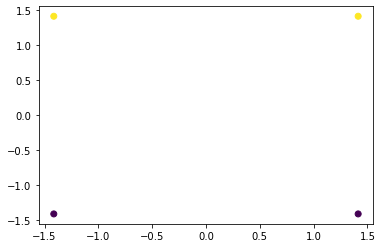

In [4]:
p_X = phi(X)
plt.scatter(p_X[:, 1], p_X[:, 5], c=y)

## The Kernel Trick

In this transformed space, our Gram matrix is now defined as:

\begin{align*}
  G &= \begin{bmatrix}
        \langle \phi(x_{1}), \phi(x_{1}) \rangle & \langle \phi(x_{1}), \phi(x_{2})\rangle &  \cdots & \langle \phi(x_{1}), x_{n} \rangle \\
        \langle \phi(x_{2}), \phi(x_{1}) \rangle & \langle \phi(x_{2}), \phi(x_{2})\rangle & \cdots & \langle \phi(x_{2}), \phi(x_{n}) \rangle \\
        \vdots & \vdots & \ddots & \vdots  \\
        \langle \phi(x_{n}), \phi(x_{1}) \rangle & \langle \phi(x_{n}), \phi(x_{2})\rangle & \cdots & \langle \phi(x_{n}), \phi(x_{n}) \rangle \\
      \end{bmatrix} \\
\end{align*}

If we have a transformation $\phi(\mathbf{x}): \mathbb{R}^p \to \mathbb{R}^k$, this matrix becomes increasingly more expensive to calculate as we consider larger $k$.

Recall the transformation used in the XOR example. If we calculate the inner product of two points using this transform, we get

\begin{align*}
    \phi(\mathbf{x}) \cdot \phi(\mathbf{y}) &= \begin{bmatrix} 1 \\ \sqrt{2} x_{1} \\ \sqrt{2} x_{2} \\ x_{1}^{2} \\ x_{2}^{2} \\ \sqrt{2} x_{1}x_{2} \end{bmatrix} \begin{bmatrix} 1 \\ \sqrt{2} y_{1} \\ \sqrt{2} y_{2} \\ y_{1}^{2} \\ y_{2}^{2} \\ \sqrt{2} y_{1}y_{2} \end{bmatrix}\\
    &= 1 + 2x_{1} y_{1} + 2 x_{2} y_{2} + x_{1}^{2} y_{1}^{2} + x_{2}^{2} y_{2}^{2} + 2 x_{1} x_{2} y_{1} y_{2}\\
    &= 1 + 2(x_{1} y_{1} + x_{2} y_{2}) + (x_{1} y_{1} + x_{2} y_{2})^{2}\\
    &= (1 + \mathbf{x} \cdot \mathbf{y})^2
\end{align*}

We can therefore represent the inner product of two points as:
\begin{align*}
k(\mathbf{x}, \mathbf{y}) &= \langle \phi(\mathbf{x}), \phi(\mathbf{y}) \rangle\\
k(\mathbf{x}, \mathbf{y}) &= (1 + \mathbf{x} \cdot \mathbf{y})^{2}\\
\end{align*}

Therefore, we can redfine the Gram matrix as:
\begin{align*}
  G &= \begin{bmatrix}
        k(x_{1}, x_{1}) &  k(x_{1}, x_{2})&  \cdots &  k(x_{1}, x_{n}) \\
        k(x_{2}, x_{1}) &  k(x_{2}, x_{2})&  \cdots &  k(x_{2}, x_{n}) \\
        \vdots & \vdots & \ddots & \vdots  \\
        k(x_{n}, x_{1}) &  k(x_{n}, x_{2}) &  \cdots &  k(x_{n}, x_{n}) \\
      \end{bmatrix} \\
\end{align*}

This means that we reduce the amount of calculation needed to project the data to a higher dimension, as we simply need to calculate $\langle x, y \rangle$ where $x, y \in \mathbb{R}^p$ to retrieve the projected Gram matrix, rather than $\langle \phi(x), \phi(y) \rangle$ where $\phi(x), \phi(y) \in \mathbb{R}^k$ and $p << k$.

Therefore, we simply need to define a kernel $k(x, y): \mathbb{R}^P \to \mathbb{R}$ which can be represented by basis transformations $k(x, y) = \langle \phi(x), \phi(y) \rangle$ and then use this kernel to redefine the Gram matrix. We can then use this new Gram matrix in our algorithm to work with a projection of the original data. 

<font color='purple'>
    
#### Exercise: 
    
The **kernel perceptron** is essentially the dual perceptron, though we redefine the Gram matrix to store the pairwise inner products the points in the *projected* dataset, where these inner products are represented by a kernel.    

Implement the kernel perceptron in the stub class `KernelPerceptron`. This class should take a generic kernel and kernel arguments as a dictionary.
    
You can use the `**` operator on a Python dictionary to unpack it and pass its key-value pairs as keyword arguments.
    
eg.
    If we have `args = {"c": 100}`, then `f1(**args)` is equivalent to `f1(c=100)`.

In [5]:
class KernelPerceptron():
    def __init__(self, kernel, kernel_args={}):
        self.gram = None
        self.alphas = None
        self.kernel = kernel
        self.kernel_args = kernel_args
        
    def fit(self, X, y, max_iter=100):
        self.gram = self.kernel(X, X, **self.kernel_args)
        self.alphas = np.zeros(X.shape[0])
        self.X = X
        self.y = y
        
        for _ in range(max_iter):
            for i, x_i in enumerate(X):
                y_hat = np.sign(np.sum(self.alphas * self.y * self.gram[:, i]))
                
                if y_hat != self.y[i]:
                    self.alphas[i] += 1
                    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, x_prime in enumerate(X):
            y_pred[i] = np.sign(np.sum(self.alphas * self.y * self.kernel(self.X, x_prime, **self.kernel_args)))
            
        return y_pred 


We define the polynomial kernel as:
\begin{align*}
    K(\mathbf{x'}, \mathbf{x}) = (1 + \mathbf{x'} \cdot \mathbf{x})^d
\end{align*}

for a degree parameter $d \in \mathbf{R}$.

In [6]:
def polynomial_kernel(x, y, d=2):
    y = y.T
    return (1 + x@y)**d

In [7]:
def plot_decision_boundary(X, y, clf, ax, bias=True):
    idxs = [0, 1]
    if bias == True:
        idxs = [1, 2]
        
    x_min, x_max = X[:, idxs[0]].min() - 1, X[:, idxs[0]].max() + 1
    y_min, y_max = X[:, idxs[1]].min() - 1, X[:, idxs[1]].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x_p = np.c_[xx.ravel(), yy.ravel()]
    if bias == True:
        biases = np.ones(xx.ravel().shape[0])
        x_p = np.c_[biases.ravel(), xx.ravel(), yy.ravel()]
        
    z = clf.predict(x_p)
    z = z.reshape(xx.shape)
    ax.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.4)
    ax.scatter(X[:, idxs[0]], X[:, idxs[1]], c=y, cmap=plt.cm.RdBu)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_title(f"Decision Boundary for {clf.__class__.__name__} for {kp.kernel_args}")

In [8]:
kp = KernelPerceptron(polynomial_kernel, kernel_args={"d": 2})
kp.fit(X, y)

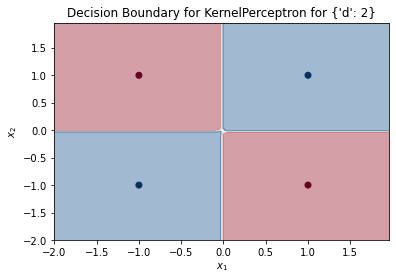

In [9]:
plot_decision_boundary(X, y, kp, plt.subplot(111))

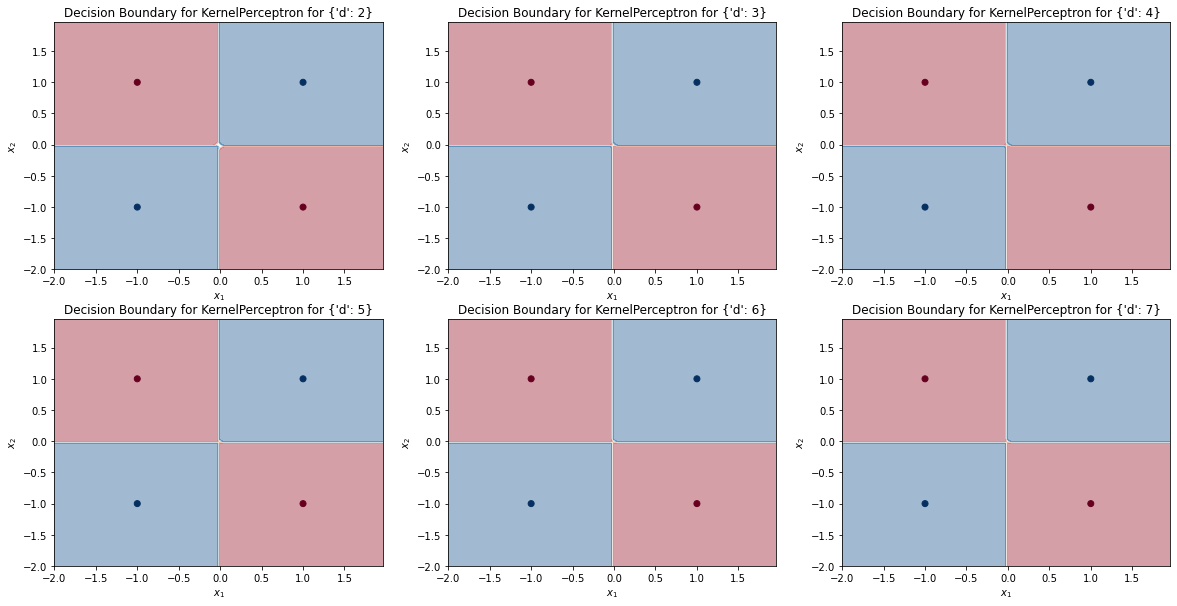

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
d_grid = np.arange(2, 8)
for i, ax in enumerate(axs.flat):
    kp = KernelPerceptron(polynomial_kernel, kernel_args={"d": d_grid[i]})
    kp.fit(X, y)
    plot_decision_boundary(X, y, kp, ax)

Let's visualise the SVM and its different Kernels.

[SVM-demo](https://jgreitemann.github.io/svm-demo)

In [11]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

In [12]:
X, y = make_moons(n_samples=150, noise=0.3, random_state=0)

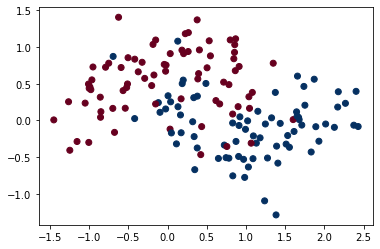

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

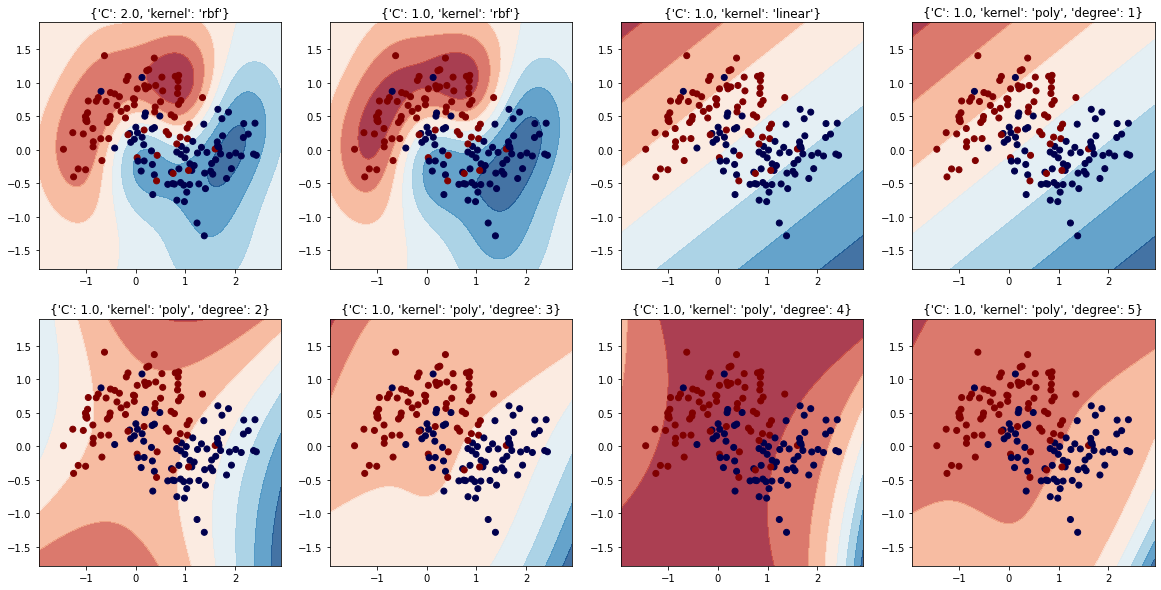

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
arg_grid = [
    {"C": 2.0, "kernel": "rbf"},
    {"C": 1.0, "kernel": "rbf"},
    {"C": 1.0, "kernel": "linear"},
    *[{"C": 1.0, "kernel": "poly", "degree": i} for i in range(1, 6)]
]
for i, (args, ax) in enumerate(zip(arg_grid, axs.flat)):
    clf = SVC(**args).fit(X, y)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5)
    ax.set_title(f"{args}")
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.seismic_r)

Visualising **hinge loss**

In [15]:
def hinge_loss(X, y, w, b):
    return np.abs(1-y*(X@w - b))

In [16]:
w = np.array([0.5, 1, 0.4])

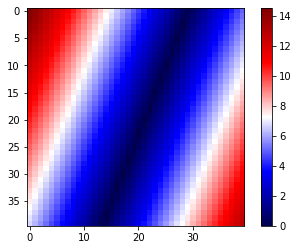

In [17]:
h = 0.5 
xx, yy = np.meshgrid(np.arange(-10, 10, h), np.arange(-10, 10, h))
y_c = np.ones(xx.ravel().shape[0])
plt.subplot(1, 1, 1)
biases = np.ones(xx.ravel().shape[0])
z = hinge_loss(np.c_[biases.ravel(), xx.ravel(), yy.ravel()], y_c, w, 0)
z = z.reshape(xx.shape)

plt.imshow(z, cmap="seismic")
plt.colorbar()
plt.show()